# Neural Network from Scratch
Code modified from https://github.com/adventuresinML/adventures-in-ml-code/blob/master/neural_network_tutorial.py

The notation in this website is almost the same as the notation we are using in class.  Instead of $a$ the author uses $h$, and instead of $N$, the author uses $m$. (I have modified the code below to use $a$ and $N$.)

Please read about this implementation starting at page 27 from the website listed above.

In [166]:
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 
import argparse
import pickle

# 1.data from homework

# 1.1 Code from homework

<Figure size 432x288 with 0 Axes>

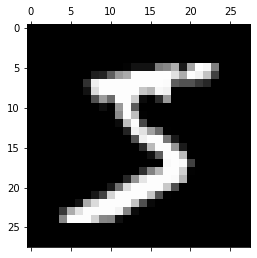

In [167]:
## data from http://yann.lecun.com/exdb/mnist/
import gzip
def extract_data(filename, num_images, IMAGE_WIDTH):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_WIDTH * IMAGE_WIDTH * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, IMAGE_WIDTH*IMAGE_WIDTH)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels
    #m =50
    #digits = load_digits()
    #X = digits.data
num_data = 500
X = extract_data('train-images-idx3-ubyte.gz', num_data, 28)

y = extract_labels('train-labels-idx1-ubyte.gz', num_data)
    #y_dash = np.array([[yy] for yy in digits.target])
    #y_dash = extract_labels('train-labels-idx1-ubyte.gz', m).reshape(m,1)
X = X.reshape(int(num_data*784/28/28),28,28)
plt.gray()
plt.matshow(X[0])
plt.show()

The shape of the digits dataset:
(1797, 64)


<Figure size 432x288 with 0 Axes>

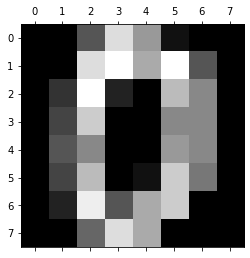

[0]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [168]:
digits=load_digits()
X = digits.data
print("The shape of the digits dataset:") 
print(digits.data.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()
y = digits.target
print(y[0:1])
print(X[0,:])

Scale the dataset

In [169]:
X.shape

(1797, 64)

In [170]:
y.shape

(1797,)

In [171]:
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)

X[0,:] # Looking the new features after scaling


array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
       -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
        0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
       -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
       -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
        0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
        1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
       -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
       -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
        0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
        1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
       -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
       -0.36677122, -1.14664746, -0.5056698 , -0.19600752])

Creating training and test datasets

In [172]:
#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


Setting up the output layer

In [173]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

Converting the training and test targets to vectors 

In [174]:
# convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

In [175]:
print(y_train[0:4])
print(y_v_train[0:4])

[3 0 1 0]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [176]:
X_train.shape

(1078, 64)

In [177]:
y_v_train.shape

(1078, 10)

Creating the neural network

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [13]:
def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [14]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [15]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [16]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

## Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [17]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

## The Back Propagation Algorithm


In [18]:
W,b = setup_and_init_weights([64, 30, 10])

In [19]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

## Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

In [20]:
nn_structure = [64, 30, 10]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


### Plotting the learning curve


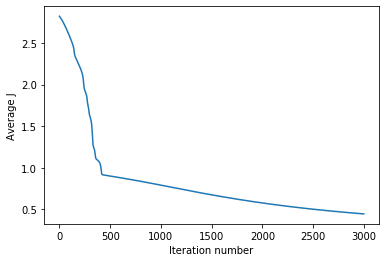

In [21]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

## 5) Assessing accuracy
Next we determine what percentage the neural network correctly predicted the handwritten digit correctly on the test set

In [23]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 88.03894297635605%


In [24]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l]+0.008/2*W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [25]:
nn_structure = [64, 30, 10]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


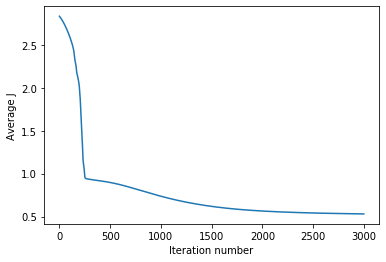

In [26]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [27]:
# get the prediction accuracy and print

y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 86.50904033379693%


# 1.2 train the data with CNN

Code modified from https://towardsdatascience.com/convolutional-neural-networks-from-the-ground-up-c67bb41454e1

In [147]:
def conv(image, label, params, conv_s, pool_f, pool_s):
    
    [f1, f2, w1, w2, b1, b2, b3, b4] = params 
    #w1 &b3 are layer1, w2 &b4 are layer 2, f1&b1 are convolution of layer1, f2&b2 are  convolution of layer2
    
    #feedforward
    conv1 = convolution(image, f1, b1, conv_s)
    conv1[conv1<=0] = 0 #use Relu instead of f(z)
    #conv1 = f(conv1)
       
    conv2 = convolution(conv1, f2, b2, conv_s)
    conv2[conv2<=0] = 0
    #conv2 = f(conv2)
    
    pooled = maxpool(conv2, pool_f, pool_s) # find the max in neighbours
    
    (nf2, dim2, _) = pooled.shape
    fc = pooled.reshape((nf2 * dim2 * dim2, 1))
    z = w1.dot(fc) + b3
    #z = f(z)
    z[z<=0] = 0 
    
    out = w2.dot(z) + b4
     
    probs = softmax(out) 
    loss = categoricalCrossEntropy(probs, label)
    
    #backpropagation

    dout = probs - label 
    dw2 = dout.dot(z.T) 
    db4 = np.sum(dout, axis = 1).reshape(b4.shape)
    
    dz = w2.T.dot(dout) 
    #dz = f_deriv(dz)
    dz[z<=0] = 0 # backpropagate through ReLU 
    dw1 = dz.dot(fc.T)
    db3 = np.sum(dz, axis = 1).reshape(b3.shape)
    
    dfc = w1.T.dot(dz) 
    dpool = dfc.reshape(pooled.shape) # reshape fully connected into dimensions of pooling layer
    
    dconv2 = maxpoolBackward(dpool, conv2, pool_f, pool_s) 
    dconv2[conv2<=0] = 0 # backpropagate through ReLU
    #dconv2 = f_deriv(dconv2)
    
    dconv1, df2, db2 = convolutionBackward(dconv2, conv1, f2, conv_s) 
    dconv1[conv1<=0] = 0 # backpropagate through ReLU
    #dconv1 = f_deriv(dconv1)
    
    dimage, df1, db1 = convolutionBackward(dconv1, image, f1, conv_s)
    
    grads = [df1, df2, dw1, dw2, db1, db2, db3, db4] 
    
    return grads, loss

In [148]:
def initializeFilter(size, scale = 1.0):
    stddev = scale/np.sqrt(np.prod(size))
    return np.random.normal(loc = 0, scale = stddev, size = size)

def initializeWeight(size):
    return np.random.standard_normal(size=size) * 0.005

In [149]:
def setup_and_init_weights_cnn(nn_structure):

    W = np.random.standard_normal(size=nn_structure)*0.01
    b = np.zeros((W.shape[0],1))
    return W, b

In [150]:
def graduate_descent(batch, num_classes, alpha, dim, n_c, beta1, beta2, params, cost):
    '''
    update the parameters through Adam gradient descent.
    '''
    [f1, f2, w1, w2, b1, b2, b3, b4] = params
    
    X = batch[:,0:-1] # get batch inputs
    X = X.reshape(len(batch), n_c, dim, dim)
    Y = batch[:,-1] # get batch labels
    
    cost_ = 0
    batch_size = len(batch)
    
    # initialize gradients and momentum,RMS params
    df1 = np.zeros(f1.shape)
    df2 = np.zeros(f2.shape)
    dw1 = np.zeros(w1.shape)
    dw2 = np.zeros(w2.shape)
    db1 = np.zeros(b1.shape)
    db2 = np.zeros(b2.shape)
    db3 = np.zeros(b3.shape)
    db4 = np.zeros(b4.shape)
    
    v1 = np.zeros(f1.shape)
    v2 = np.zeros(f2.shape)
    v3 = np.zeros(w1.shape)
    v4 = np.zeros(w2.shape)
    bv1 = np.zeros(b1.shape)
    bv2 = np.zeros(b2.shape)
    bv3 = np.zeros(b3.shape)
    bv4 = np.zeros(b4.shape)
    
    s1 = np.zeros(f1.shape)
    s2 = np.zeros(f2.shape)
    s3 = np.zeros(w1.shape)
    s4 = np.zeros(w2.shape)
    bs1 = np.zeros(b1.shape)
    bs2 = np.zeros(b2.shape)
    bs3 = np.zeros(b3.shape)
    bs4 = np.zeros(b4.shape)
    
    for i in range(batch_size):
        
        x = X[i]
        y = np.eye(num_classes)[int(Y[i])].reshape(num_classes, 1) # convert label to one-hot
        
        # Collect Gradients for training example
        grads, loss = conv(x, y, params, 1, 2, 2)
        [df1_, df2_, dw1_, dw2_, db1_, db2_, db3_, db4_] = grads
        
        df1+=df1_
        db1+=db1_
        df2+=df2_
        db2+=db2_
        dw1+=dw1_
        db3+=db3_
        dw2+=dw2_
        db4+=db4_

        cost_+= loss

    # Parameter Update  
        
    v1 = beta1*v1 + (1-beta1)*df1/batch_size # momentum update
    s1 = beta2*s1 + (1-beta2)*(df1/batch_size)**2 # RMSProp update
    f1 -= alpha * v1/np.sqrt(s1+1e-7) # combine momentum and RMSProp to perform update with Adam
    
    bv1 = beta1*bv1 + (1-beta1)*db1/batch_size
    bs1 = beta2*bs1 + (1-beta2)*(db1/batch_size)**2
    b1 -= alpha * bv1/np.sqrt(bs1+1e-7)
   
    v2 = beta1*v2 + (1-beta1)*df2/batch_size
    s2 = beta2*s2 + (1-beta2)*(df2/batch_size)**2
    f2 -= alpha * v2/np.sqrt(s2+1e-7)
                       
    bv2 = beta1*bv2 + (1-beta1) * db2/batch_size
    bs2 = beta2*bs2 + (1-beta2)*(db2/batch_size)**2
    b2 -= alpha * bv2/np.sqrt(bs2+1e-7)
    
    v3 = beta1*v3 + (1-beta1) * dw1/batch_size
    s3 = beta2*s3 + (1-beta2)*(dw1/batch_size)**2
    w1 -= alpha * v3/np.sqrt(s3+1e-7)
    
    bv3 = beta1*bv3 + (1-beta1) * db3/batch_size
    bs3 = beta2*bs3 + (1-beta2)*(db3/batch_size)**2
    b3 -= alpha * bv3/np.sqrt(bs3+1e-7)
    
    v4 = beta1*v4 + (1-beta1) * dw2/batch_size
    s4 = beta2*s4 + (1-beta2)*(dw2/batch_size)**2
    w2 -= alpha * v4 / np.sqrt(s4+1e-7)
    
    bv4 = beta1*bv4 + (1-beta1)*db4/batch_size
    bs4 = beta2*bs4 + (1-beta2)*(db4/batch_size)**2
    b4 -= alpha * bv4 / np.sqrt(bs4+1e-7)
    

    cost_ = cost_/batch_size
    cost.append(cost_)

    params = [f1, f2, w1, w2, b1, b2, b3, b4]
    
    return params, cost

In [151]:
def train(X,y,num_classes = 10, alpha = 0.01, beta1 = 0.95, beta2 = 0.99, img_dim = 8, img_depth = 1, f = 5, num_filt1 = 32, num_filt2 = 32, batch_size = 32, num_epochs = 2):
    # after you change the img_dim, you should change f as well as w3(line208 to make sure two matrix can dot)
    # training data

    #m =50
    #digits = load_digits()
    #X = digits.data
    #X = extract_data('train-images-idx3-ubyte.gz', m, img_dim)

    
    #y_dash = np.array([[yy] for yy in digits.target])
    #y_dash = extract_labels('train-labels-idx1-ubyte.gz', m).reshape(m,1)
    train_data = np.hstack((X,y))
    
    np.random.shuffle(train_data)

    ## Initializing all the parameters
    if img_dim ==28:
        f = 5
        num_filt1 = 8
        num_filt2 = 8
        f1, f2, w1, w2 = (num_filt1 ,img_depth,f,f), (num_filt2 ,num_filt1,f,f), (128,800), (10, 128)

    elif img_dim == 8:
        f = 2
        f1, f2, w1, w2 = (num_filt1 ,img_depth,f,f), (num_filt2 ,num_filt1,f,f), (128,288), (10, 128)
    else:
        print("Thia img_dim has not been implemented")
    f1 = initializeFilter(f1)
    f2 = initializeFilter(f2)
    w1,b3 = setup_and_init_weights_cnn(w1)
    w2,b4 = setup_and_init_weights_cnn(w2)
    b1 = np.zeros((f1.shape[0],1))
    b2 = np.zeros((f2.shape[0],1))

    params = [f1, f2, w1, w2, b1, b2, b3, b4]

    cost = []

    print("LR:"+str(alpha)+", Batch Size:"+str(batch_size))

    for epoch in range(num_epochs):
        np.random.shuffle(train_data)
        batches = [train_data[k:k + batch_size] for k in range(0, train_data.shape[0], batch_size)]
        for batch in batches:
            params, cost = graduate_descent(batch, num_classes, alpha, img_dim, img_depth, beta1, beta2, params, cost)
    
    return (params, cost)

In [152]:
def convolution(image, filt, bias, s=1):
    '''
    Confolves `filt` over `image` using stride `s`
    '''
    (n_f, n_c_f, f, _) = filt.shape # filter dimensions
    n_c, in_dim, _ = image.shape # image dimensions
    
    out_dim = int((in_dim - f)/s)+1 # calculate output dimensions
    
    
    out = np.zeros((n_f,out_dim,out_dim))
    
    # convolve the filter over every part of the image, adding the bias at each step. 
    for curr_f in range(n_f):
        curr_y = out_y = 0
        while curr_y + f <= in_dim:
            curr_x = out_x = 0
            while curr_x + f <= in_dim:
                out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return out

In [153]:
def maxpool(image, f=2, s=2):
    '''
    Downsample `image` using kernel size `f` and stride `s`
    '''
    n_c, h_prev, w_prev = image.shape
    
    h = int((h_prev - f)/s)+1
    w = int((w_prev - f)/s)+1
    
    downsampled = np.zeros((n_c, h, w))
    for i in range(n_c):
        # slide maxpool window over each part of the image and assign the max value at each step to the output
        curr_y = out_y = 0
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            while curr_x + f <= w_prev:
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    return downsampled
def softmax(X):
    out = np.exp(X)
    return out/np.sum(out)
def categoricalCrossEntropy(probs, label):
    return -np.sum(label * np.log(probs))

In [154]:
def convolutionBackward(dconv_prev, conv_in, filt, s):
    '''
    Backpropagation through a convolutional layer. 
    '''
    (n_f, n_c, f, _) = filt.shape
    (_, orig_dim, _) = conv_in.shape
    ## initialize derivatives
    dout = np.zeros(conv_in.shape) 
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f,1))
    for curr_f in range(n_f):
        # loop through all filters
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # loss gradient of filter (used to update the filter)
                dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f] 
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        # loss gradient of the bias
        dbias[curr_f] = np.sum(dconv_prev[curr_f])
    
    return dout, dfilt, dbias

In [155]:
def maxpoolBackward(dpool, orig, f, s):
    '''
    Backpropagation through a maxpooling layer. The gradients are passed through the indices of greatest value in the original maxpooling during the forward step.
    '''
    (n_c, orig_dim, _) = orig.shape
    
    dout = np.zeros(orig.shape)
    
    for curr_c in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # obtain index of largest value in input for current window
                (a, b) = nanargmax(orig[curr_c, curr_y:curr_y+f, curr_x:curr_x+f])
                dout[curr_c, curr_y+a, curr_x+b] = dpool[curr_c, out_y, out_x]
                
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return dout

In [156]:
def nanargmax(arr):
    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape)
    return idxs 

In [162]:
digits = load_digits()
X = digits.data
y = np.array([[yy] for yy in digits.target])
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, test_size=0.4)
img_dim = 8
(params, cost) = train(X = X_train, y = y_train,alpha = 0.02, img_dim = img_dim)

LR:0.02, Batch Size:32


In [163]:
[f1, f2, w1, w2, b1, b2, b3, b4] = params

In [164]:
def predict(image, f1, f2, w1, w2, b1, b2, b3, b4, conv_s = 1, pool_f = 2, pool_s = 2):
    '''
    Make predictions with trained filters/weights. 
    '''
    conv1 = convolution(image, f1, b1, conv_s) # convolution operation
    conv1[conv1<=0] = 0 #relu activation
    
    conv2 = convolution(conv1, f2, b2, conv_s) # second convolution operation
    conv2[conv2<=0] = 0 # pass through ReLU non-linearity
    
    pooled = maxpool(conv2, pool_f, pool_s) # maxpooling operation
    (nf2, dim2, _) = pooled.shape
    fc = pooled.reshape((nf2 * dim2 * dim2, 1)) # flatten pooled layer
    
    z = w1.dot(fc) + b3 # first dense layer
    z[z<=0] = 0 # pass through ReLU non-linearity
    
    out = w2.dot(z) + b4 # second dense layer
    probs = softmax(out) # predict class probabilities with the softmax activation function
    
    return np.argmax(probs), np.max(probs)

In [165]:
X = X_test
y_dash = y_test
X-= int(np.mean(X)) # subtract mean
X/= int(np.std(X)) # divide by standard deviation
test_data = np.hstack((X,y_dash))
    
X = test_data[:,0:-1]
X = X.reshape(len(test_data), 1,img_dim, img_dim)
y = test_data[:,-1]

corr = 0
digit_count = [0 for i in range(10)]
digit_correct = [0 for i in range(10)]
   
#t = tqdm(range(len(X)), leave=True)

for i in range(len(X)):
    x = X[i]
    pred, prob = predict(x, f1, f2, w1, w2, b1, b2, b3, b4)
    digit_count[int(y[i])]+=1
    if pred==y[i]:
        corr+=1
        digit_correct[pred]+=1

   # t.set_description("Acc:%0.2f%%" % (float(corr/(i+1))*100))
        
print("ACC: "+ str(float(corr/len(test_data)*100)))

ACC: 93.46314325452016


## 2 data from http://yann.lecun.com/exdb/mnist/

## 2.1 Using the network in homework

<Figure size 432x288 with 0 Axes>

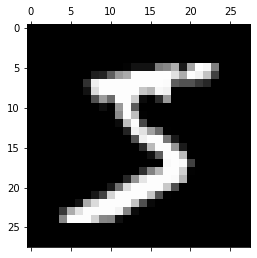

In [129]:
## data from http://yann.lecun.com/exdb/mnist/
import gzip
def extract_data(filename, num_images, IMAGE_WIDTH):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_WIDTH * IMAGE_WIDTH * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, IMAGE_WIDTH*IMAGE_WIDTH)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels
    #m =50
    #digits = load_digits()
    #X = digits.data
num_data = 1000
X_train = extract_data('train-images-idx3-ubyte.gz', num_data, 28)

y_train = extract_labels('train-labels-idx1-ubyte.gz', num_data)

X_test = extract_data('t10k-images-idx3-ubyte.gz', num_data, 28)
y_test = extract_labels('t10k-labels-idx1-ubyte.gz', num_data)
    #y_dash = np.array([[yy] for yy in digits.target])
    #y_dash = extract_labels('train-labels-idx1-ubyte.gz', m).reshape(m,1)
X_train = X_train.reshape(num_data,28,28)

plt.gray()
plt.matshow(X_train[0])
plt.show()
X_train = X_train.reshape(num_data,28*28)
X_test = X_test.reshape(num_data,28*28)

In [130]:
X_train-= int(np.mean(X_train))
X_train/= int(np.std(X_train))
X_test-= int(np.mean(X_test))
X_test/= int(np.std(X_test))

X_train[0].shape # Looking the new features after scaling


(784,)

In [131]:
X_train.shape

(1000, 784)

In [132]:
y_v_train.shape

(300, 10)

In [133]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

In [134]:
#Split the data into training and test set.  60% training and %40 test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


In [135]:
# convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

In [136]:
W,b = setup_and_init_weights([64, 30, 10])

In [137]:
nn_structure = [784, 30, 10]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


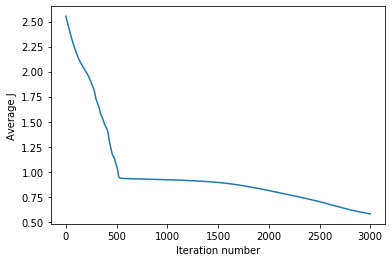

In [138]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [139]:
# get the prediction accuracy and print

y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 75.6%


## 2.2 Using CNN

In [140]:
num_data =3000
X = extract_data('train-images-idx3-ubyte.gz', num_data, 28)
y = extract_labels('train-labels-idx1-ubyte.gz', num_data).reshape(num_data,1)
#X_scale = StandardScaler()
#X = X_scale.fit_transform(X)
X-= int(np.mean(X))
X/= int(np.std(X))
img_dim = 28


In [141]:
#num_data =500
#X = extract_data('train-images-idx3-ubyte.gz', num_data, 28)
#y_dash = extract_labels('train-labels-idx1-ubyte.gz', num_data).reshape(num_data,1)

#train_data = np.hstack((X,y_dash))

In [142]:
(params, cost) = train(X = X, y = y,img_dim = img_dim)

LR:0.01, Batch Size:32


In [143]:
y.shape

(3000, 1)

In [144]:
num_data = 500
X = extract_data('t10k-images-idx3-ubyte.gz', num_data, 28)
y_dash = extract_labels('t10k-labels-idx1-ubyte.gz', num_data).reshape(num_data,1)
    # Normalize the data
X-= int(np.mean(X)) # subtract mean
X/= int(np.std(X)) # divide by standard deviation
test_data = np.hstack((X,y_dash))
    
X = test_data[:,0:-1]
X = X.reshape(len(test_data), 1, 28, 28)
y = test_data[:,-1]

corr = 0
digit_count = [0 for i in range(10)]
digit_correct = [0 for i in range(10)]
   

(f1, f2, w1, w2, b1, b2, b3, b4) = params
for i in range(len(X)):
    x = X[i]
    pred, prob = predict(x, f1, f2, w1, w2, b1, b2, b3, b4)
    digit_count[int(y[i])]+=1
    if pred==y[i]:
        corr+=1
        digit_correct[pred]+=1
print("ACC:" +str(float(corr/len(test_data)*100)))
"""
x = np.arange(10)
digit_recall = [x/y for x,y in zip(digit_correct, digit_count)]
plt.xlabel('Digits')
plt.ylabel('Recall')
plt.title("Recall on Test Set")
plt.bar(x,digit_recall)
plt.show()
"""

ACC:94.0


'\nx = np.arange(10)\ndigit_recall = [x/y for x,y in zip(digit_correct, digit_count)]\nplt.xlabel(\'Digits\')\nplt.ylabel(\'Recall\')\nplt.title("Recall on Test Set")\nplt.bar(x,digit_recall)\nplt.show()\n'

# Results

In [ ]:
Extension: compare CNN with neural network in homework with 2 different dataset to see the differece of their performance

For the dataset in homework(1078 samples for traing, 719 samples for test), the neural network in the homework performs better.
For minst data（3000 samples for training, 500 samples for test）, CNN performs better.
One of the possible reasons is that the data in homework is 8*8 pixels and minst data is 28*28 pixels.
Since CNN needs to extract shape from figure and filter the image with a small window to find the significant pixel, it can find the shape with image with more pixels. However, if the image is too small, this method doesn't help much.